# SRGAN

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage.metrics import structural_similarity as ssim
from data import DIV2K
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer
#import tensorflow.python.ops.numpy_ops.np_config

%matplotlib inline

In [3]:
# pre-trained weights
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

## Datasets

In [ ]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')

In [ ]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

## Training

In [ ]:
pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')
pre_trainer.train(train_ds,
                  valid_ds.take(10),
                  steps=1000000, 
                  evaluate_every=1000, 
                  save_best_only=False)

pre_trainer.model.save_weights(weights_file('pre_generator.h5'))

In [ ]:
gan_generator = generator()
gan_generator.load_weights(weights_file('pre_generator.h5'))

gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())
gan_trainer.train(train_ds, steps=200000)

In [ ]:
gan_trainer.generator.save_weights(weights_file('gan_generator.h5'))
gan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))

## Testing

In [4]:
## function for peak signal-to-noise ratio (PSNR)

def psnr(target, ref):
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten(order='C')
    
    ## root mean squared error
    rmse = math.sqrt(np.mean(diff ** 2.))
    
    return 20 * math.log10(255. / rmse)      ## peak signal-to-noise ratio 

## function for mean squared error(MSE)
def mse(target, ref):
    err = np.sum( (target.astype(float) - ref.astype(float)) ** 2 )
    err /= float(target.shape[0] * target.shape[1])
    
    return err

## function for combining all three metrics
def compare_images(target, ref):
    scores = []
    
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))  
    
    return scores

In [5]:
pre_generator = generator()
gan_generator = generator()

pre_generator.load_weights(weights_file('pre_generator.h5'))
gan_generator.load_weights(weights_file('gan_generator.h5'))

In [6]:
from model import resolve_single
from utils import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr, gan_sr]
    target=lr
    ref=pre_sr
    
    scores = compare_images(np.asarray(pre_sr),np.asarray(gan_sr))
    titles = ['Degraded', 'SRGAN']
    positions = [1, 2]
    
    return images,titles,positions,scores

PSNR:  38.10772371719169
MSE:  30.159854627071823
SSIM:  0.9730911090767566


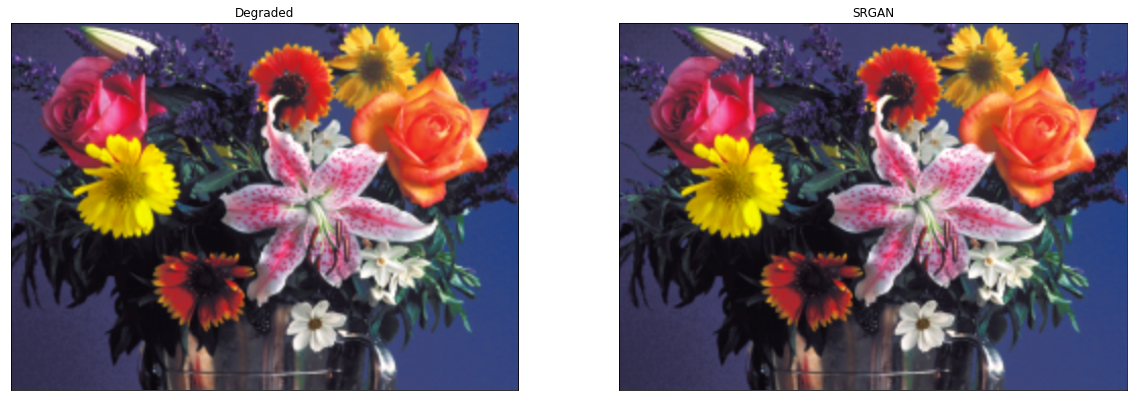

In [8]:
images,titles,positions,scores = resolve_and_plot('demo/flowers.bmp')  

for i, (img, title, pos,score) in enumerate(zip(images, titles, positions,scores)):
    plt.subplot(2, 2, pos)
    plt.imshow(img)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
 

print("PSNR: ",scores[0])
print("MSE: ",scores[1])
print("SSIM: " ,scores[2])